In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob


# Zonal Mean Online Bias

In this notebook, we show how we generate zonal mean bias plots, i.e., Figure 3, 4, 5, and G1 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [2]:

data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'
data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'

data_path_docker = "/media/peter/samlinux/soft/ClimSim-Online/climsim-online/scratch/"

ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


In [3]:
import numpy as np 

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

## Read the 5-year U-Net hybrid simulation and MMF reference simulation monthly data

## Visualize the 5-year mean zonal mean values and biases of state variables (e.g, T, Q) and tendency variables (e.g., dT/dt, dQ/dt)

These correspond to the Figure 4 and 5 in Hu et al. 2024.

In [19]:
sp_tmean.shape

(384, 60)

In [21]:
sp_zm.shape

(18, 60)

## RNN simulation

We can see that the 5-year online bias can vary due to change of NN checkpoint, although some bias patterns remain similar (e.g., tropical dry moisture bias and negative liquid cloud bias). Figure G1 in Hu et al. 2024.

In [9]:
yearstr = '1year'

#pattern = '*.eam.h0.000[3-8]*.nc'
pattern = '*.eam.h0.000[1-4]*.nc'
pattern = '*.eam.h0.0003-0[1-9].nc'
pattern = '*.eam.h0.0003-*.nc'
#pattern = '*.eam.h0.0003-0[1-6].nc'

#pattern = "example_job_submit_nnwrapper_v4_constrained_rnn_65791.eam.h0.0003.nc"

#filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_3x96/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/'+yearstr+'/RNN/huber/'+pattern
filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_3x96_warmup/'+pattern
filenames = data_path+'h0/'+yearstr+'/RNN/23192/'+pattern # best so far with temp, u but bad cld
#filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_160/'+pattern
#filenames = data_path+'h0/'+yearstr+'/RNN/nomp_83377/'+pattern # horrible
filenames = data_path+'h0/'+yearstr+'/RNN/44482_2/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/seprad_29116/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/77672/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/5695/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/srnn_35771/'+pattern  # bad liqcld

#filenames = data_path+'h0/'+yearstr+'/RNN/46784/'+pattern # best so far but still bad cld liq?
#filenames = data_path+'h0/'+yearstr+'/RNN/34836/'+pattern  # clouds BEST SO FAR -- 192 192 16  water2e7
#filenames = data_path+'h0/'+yearstr+'/RNN/newwc_27497/'+pattern  # ALMOST AS GOOD as 34.. - 160-160-160 wconv2_2e7

#filenames = data_path+'h0/'+yearstr+'/RNN/86012/'+pattern  # nolevscale, small offline val biases in clds (large tr), but online bias liq clds up to 300
#filenames = data_path+'h0/'+yearstr+'/RNN/sgru_86011/'+pattern  # best offline biases yet , but BAD, liqcld up to 3000
#filenames = data_path+'h0/'+yearstr+'/RNN/newwc_27497/'+pattern  # ALMOST AS GOOD as 34.. - 160-160-160 wconv2_2e7
#filenames = data_path+'h0/'+yearstr+'/RNN/sgru_41990/'+pattern  # liqcld up to 3000
#filenames = data_path+'h0/'+yearstr+'/RNN/mp2_48581/'+pattern  # high lqicld bias 1250
# 67499 : mp2-seprad-wcon3e7 very high hcon loss - crash

#filenames = data_path+'h0/'+yearstr+'/RNN/67499/'+pattern  # seprad mp2 wcon2 very bad hcon     rubbish, up to 8k

#filenames = data_path+'h0/'+yearstr+'/RNN/longwcon_16421/'+pattern  # Liq cld BEST SO FAR

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_89507/'+pattern  #  horrible liq

#filenames = data_path+'h0/'+yearstr+'/RNN/58348/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/58348_ep2/'+pattern  # 

#filenames = data_path+'h0/'+yearstr+'/RNN/65791/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_62843/'+pattern  #               PERTURBRNN NOT BAD
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_1dn_47987/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_192/'+pattern  # 

# Previous tendencies

#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_160_wcon/'+pattern  #    BEST SO FAR?

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160_31967/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160_665/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_96160/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/2134/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep13/'+pattern  # really bad cld
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep21/'+pattern  #  FIXED IT! link to lower offline cld bias?
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep28/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep34/'+pattern  #   pretty good
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep36/'+pattern  #   best liq cld????????????????

# nomem, no water loss - large cloud errors
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_49430/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_91940/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_22056/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_fulldata_3150/'+pattern  #  good apart from liq
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_43000_ep7/'+pattern   # 192. godawful
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_43000_ep14/'+pattern   # 192. no better!

# Mem, fulldata, trained long time
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_34897/'+pattern  # absolutely disastrous 
# trained less
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_86705/'+pattern  # very bad liq
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_86705_ep8/'+pattern  # trained even less: better liq but worse everything else
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_43301/'+pattern  # rubbish
#filenames = data_path+'h0/'+yearstr+'/RNN/8415/'+pattern  # 


#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_16992/'+pattern  # OneCycle. PRETTY GOOD
# OneCycle with time averaged h-loss; early epoch with bad offline cld biases
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576/'+pattern  # REALLY BAD CLD ERRORS
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576_ep13/'+pattern  # EVEN WORSE!!!
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576_fin/'+pattern  # CRASHED!

# SRNN StochLSTM144
#filenames = data_path+'h0/'+yearstr+'/RNN/srnn_79482/'+pattern  # liq cld  bad
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_63117/'+pattern  # not bad!
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep2/'+pattern  # quite big ice errors
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep4/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep6/'+pattern  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep14/'+pattern  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep18/'+pattern  

filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_62843/'+pattern  #   no prevT, pretty good!
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_7285/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_1dn_47987/'+pattern  # 

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_64972_ep4/'+pattern  # prevT
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_perturb_78097/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_91428_ep5/'+pattern  # 
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_53373_ep5/'+pattern  # 
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_55050_ep1/'+pattern  #  mp-1
# Prevtend mp0
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0_55622/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0_10536/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/lstm_mp0_52318/'+pattern  #  

filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_36534/run/"+pattern
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_62905/run/"+pattern
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_51230/run/"+pattern
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_88067/run/"+pattern #  mp-1
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_72844/run/"+pattern
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_40289/run/"+pattern



print(filenames)
ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
print("Shape pred:", ds_nn.T.shape)
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/'+yearstr+'/mmf_ref/months/'+pattern
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
print("Shape true:", ds_sp.T.shape)
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

import numpy as np 

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

/media/peter/samlinux/soft/ClimSim-Online/climsim-online/scratch//example_job_submit_nnwrapper_v4_rnn_40289/run/*.eam.h0.0003-*.nc
Shape pred: (11, 60, 384)
Shape true: (11, 60, 384)


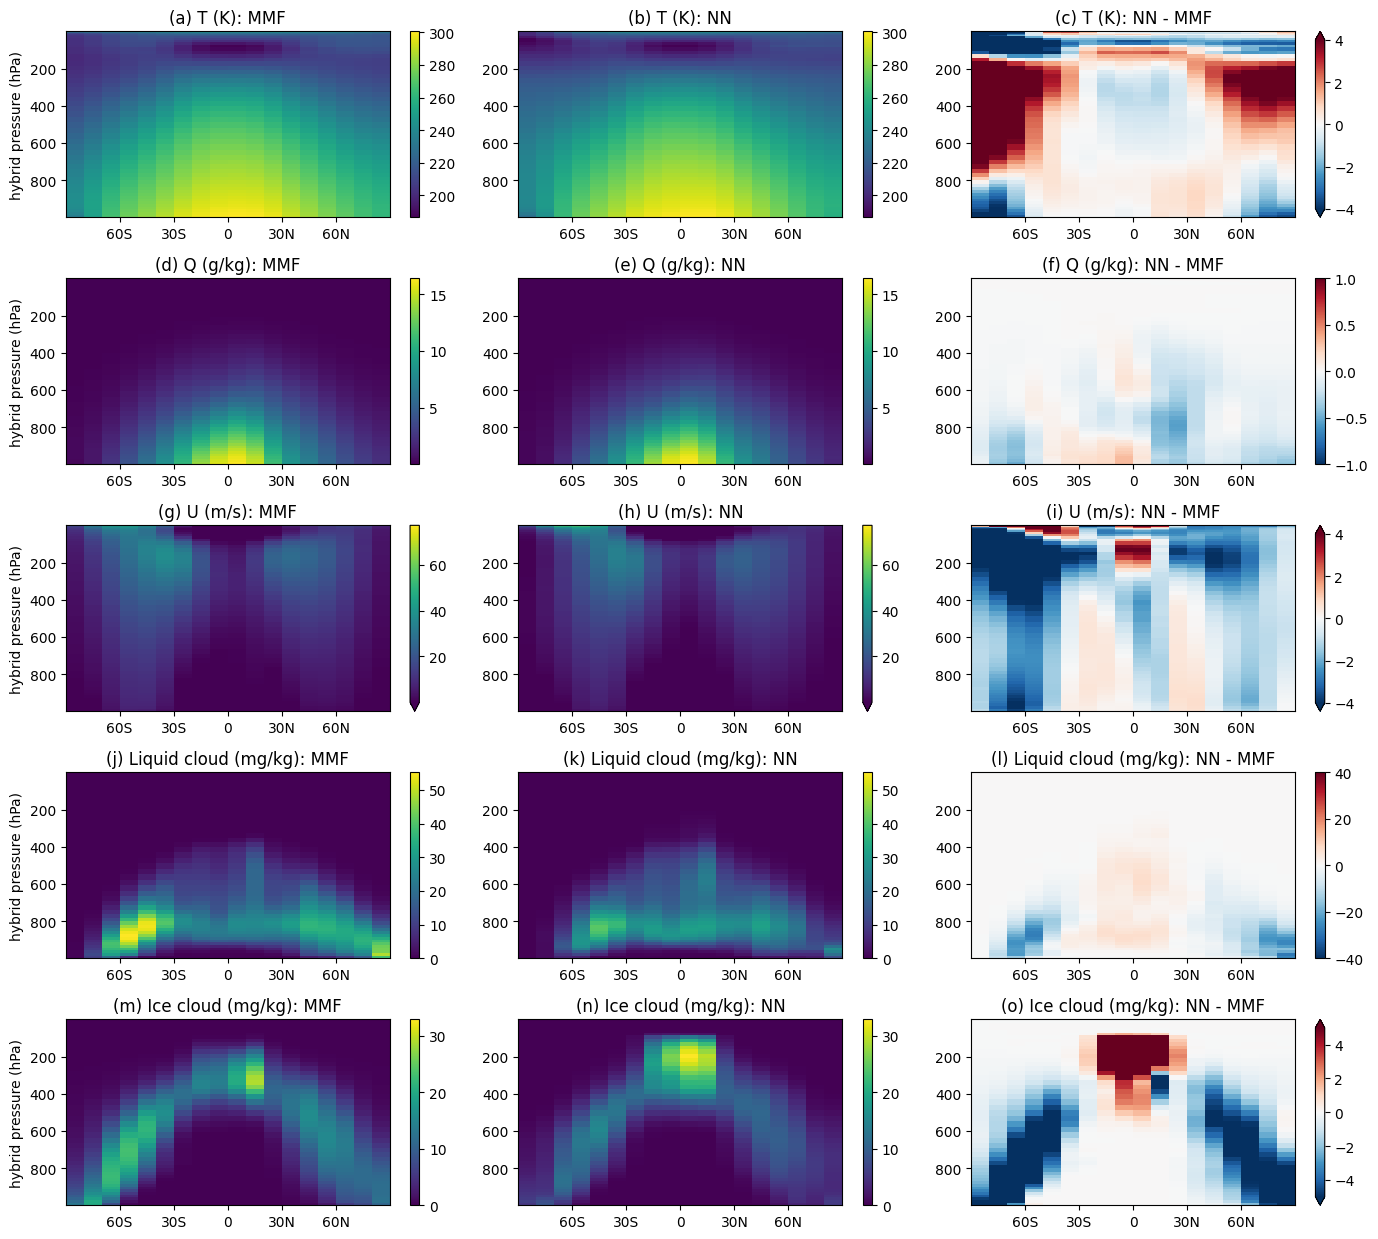

In [5]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 4},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r' , vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


In [86]:
ds_nn['CLDICE']

<xarray.DataArray 'CLDICE' (time: 11, lev: 60, ncol: 384)> Size: 1MB
dask.array<getitem, shape=(11, 60, 384), dtype=float32, chunksize=(1, 60, 384), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * time     (time) object 88B 0003-03-01 00:00:00 ... 0004-01-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/kg
    mixing_ratio:  wet
    long_name:     Grid box averaged cld ice amount
    cell_methods:  time: mean

Shape true: (10, 60, 384)
Shape true: (10, 60, 384)


/tmp/ipykernel_136304/1662798496.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


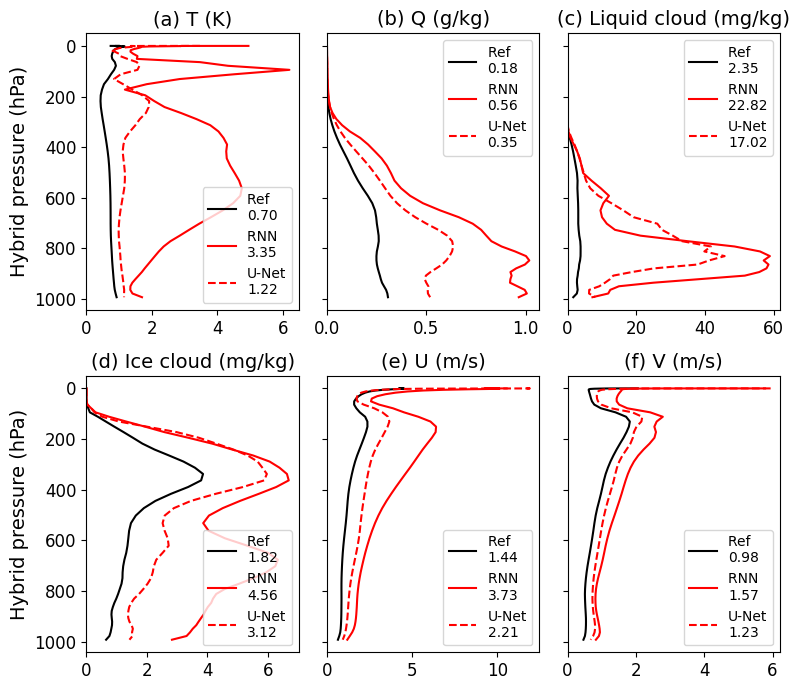

In [106]:
area_weight = grid_area/np.sum(grid_area)

pattern2 = '*eam*nc'
filenames = data_path+'h0/'+yearstr+'/mmf_a/'+pattern2
ds_sp2 = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp2 = ds_sp2.sel(time=ds_sp.time[1:])
print("Shape true:", ds_sp2.T.shape)
ds_sp2['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/'+yearstr+'/unet_v5/huber_rop/'+pattern2
ds_nn2 = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_nn2 = ds_nn2.sel(time=ds_sp.time[1:])
print("Shape true:", ds_nn2.T.shape)
ds_nn2['lev'].attrs['long_name'] = 'hybrid pressure'

variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
scaling_dict = {'T': 1.0, 'Q': 1000.0, 'CLDLIQ': 1e6, 'CLDICE': 1e6, 'U': 1.0, 'V': 1.0}  # Scaling factors
units_dict = {'T': 'K', 'Q': 'g/kg', 'CLDLIQ': 'mg/kg', 'CLDICE': 'mg/kg', 'U': 'm/s', 'V': 'm/s'}  # Units
titles = [
    '(a) T',
    '(b) Q',
    '(c) Liquid cloud',
    '(d) Ice cloud',
    '(e) U',
    '(f) V',
]  # Main titles with subplot labels

fig, axes = plt.subplots(2, 3, figsize=(8, 7), sharey=True, constrained_layout=True)  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten axes for easier iteration

for ax, var, title in zip(axes, variables, titles):
    # Use specified scaling for the variable
    scaling = scaling_dict[var]

    # Compute time-mean and RMSE for each variable
    nn_tmean = (ds_nn[var]).mean(dim=('time')).compute().values * scaling
    nn_tmean2 = (ds_nn2[var]).mean(dim=('time')).compute().values * scaling
    sp_tmean = (ds_sp[var]).mean(dim=('time')).compute().values * scaling
    sp_tmean2 = (ds_sp2[var]).mean(dim=('time')).compute().values * scaling

    nn_rmse = np.sqrt(np.average((sp_tmean - nn_tmean) ** 2, axis=1, weights=area_weight))
    nn_rmse2 = np.sqrt(np.average((sp_tmean - nn_tmean2) ** 2, axis=1, weights=area_weight))
    mmf_rmse = np.sqrt(np.average((sp_tmean - sp_tmean2) ** 2, axis=1, weights=area_weight))

    nn_rmse_global = np.sqrt(np.average((sp_tmean - nn_tmean) ** 2, weights=total_weight))
    nn_rmse_global2 = np.sqrt(np.average((sp_tmean - nn_tmean2) ** 2, weights=total_weight))
    mmf_rmse_global = np.sqrt(np.average((sp_tmean - sp_tmean2) ** 2, weights=total_weight))

    # Plot on the corresponding axis
    ax.plot(mmf_rmse, lev, label=f'Ref \n{mmf_rmse_global:.2f}', linestyle='-', color='black')
    ax.plot(nn_rmse, lev, label=f'RNN \n{nn_rmse_global:.2f}', color='red')
    ax.plot(nn_rmse2, lev, label=f'U-Net\n{nn_rmse_global2:.2f}', color='red', linestyle='dashed')
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title(title+f' ({units_dict[var]})', fontsize=14, loc='center')  # Add main title with subplot label
    # ax.set_xlabel(f'{units_dict[var]}', fontsize=14)  # Keep unit in x-label
    ax.invert_yaxis()  # Reverse the y-axis
    ax.legend(fontsize=10)

# Set a shared y-label for the first column
axes[0].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
axes[3].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
# plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()

In [23]:
data_sp

<xarray.DataArray (hybrid pressure (hPa): 60, latitude: 18)> Size: 9kB
array([[3.70721706e-08, 3.70797160e-08, 3.70971491e-08, ...,
        3.84535116e-08, 3.86647459e-08, 3.88016992e-08],
       [3.73468710e-08, 3.73577177e-08, 3.73856530e-08, ...,
        3.82520312e-08, 3.85094983e-08, 3.86696570e-08],
       [3.76815346e-08, 3.77039763e-08, 3.78030149e-08, ...,
        3.81596296e-08, 3.84424594e-08, 3.86084140e-08],
       ...,
       [1.04336950e+01, 1.87317282e+01, 1.28835628e+01, ...,
        8.30566082e+00, 8.78193328e+00, 1.21389623e+01],
       [1.14939585e+01, 1.99131125e+01, 1.09433486e+01, ...,
        7.50881474e+00, 8.38614575e+00, 1.23910208e+01],
       [1.30222425e+01, 1.99112944e+01, 7.75771256e+00, ...,
        5.65184051e+00, 7.40979630e+00, 1.08921404e+01]])
Coordinates:
  * hybrid pressure (hPa)  (hybrid pressure (hPa)) float64 480B 0.07835 ... 9...
  * latitude               (latitude) int64 144B -85 -75 -65 -55 ... 55 65 75 85

## Zonal mean cloud liquid and ice zonal mean bias in unconstrained U-Net hybrid simulation exploded

Below we compare a single month's cloud liquid and ice zonal mean bias in reference MMF simulation, unconstrained U-Net, and constrained U-Net hybrid simulations. This month is where we observe that the unconstrained U-Net model experience rapid error growth.

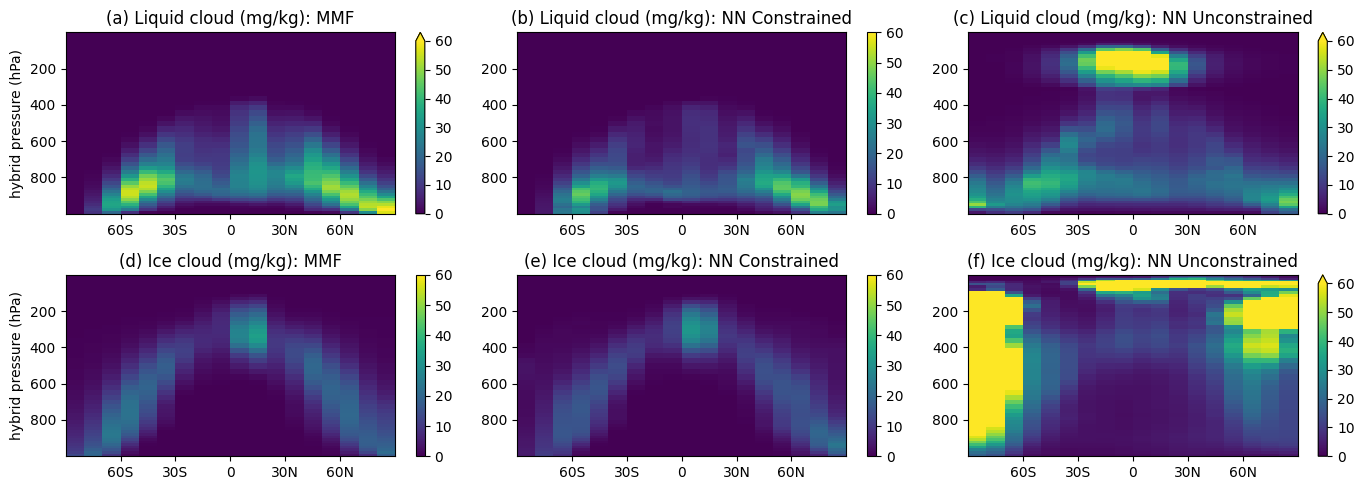

In [40]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# Load the datasets
ds_sp = xr.open_dataset(data_path + 'h0/1year/mmf_ref/mmf_ref.eam.h0.0003.nc')
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'
ds_sp = ds_sp.isel(time=9)

ds_v4 = xr.open_dataset(data_path + 'h0/1year/unet_v4/huber_rop/v4_noclassifier_huber_1y_noaggressive_nomodifystqn_rop2_uoutputprune.eam.h0.0003-10.nc')
ds_v4['lev'].attrs['long_name'] = 'hybrid pressure'

ds_v5 = xr.open_dataset(data_path + 'h0/1year/unet_v5/huber_rop/v5_noclassifier_huber_1y_noaggressive_rop2.eam.h0.0003-10.nc')
ds_v5['lev'].attrs['long_name'] = 'hybrid pressure'

# List of variables and their settings for the two rows
variables = [
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 5))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]

vmaxs = [60,60]

# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].compute().transpose('ncol', 'lev')
    nn_tmean_v4 = ds_v4[var][0,:,:].compute().transpose('ncol', 'lev')
    nn_tmean_v5 = ds_v5[var][0,:,:].compute().transpose('ncol', 'lev')
    
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm_v4, lats_sorted = zonal_mean_area_weighted(nn_tmean_v4, grid_area, lat)
    nn_zm_v5, lats_sorted = zonal_mean_area_weighted(nn_tmean_v5, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v4 = scaling * xr.DataArray(nn_zm_v4[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v5 = scaling * xr.DataArray(nn_zm_v5[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})

    vmax = vmaxs[idx]
    vmin=0
    
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn_v4.plot(ax=axs[idx, 2], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN Unconstrained')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

    
    data_nn_v5.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN Constrained')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot


    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


In [14]:
ds_sp

<xarray.Dataset> Size: 561kB
Dimensions:    (ncol: 384, lev: 60, ilev: 61, nbnd: 2)
Coordinates:
  * lev        (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev       (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
    time       object 8B 0003-11-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/14)
    area       (ncol) float64 3kB ...
    hyam       (lev) float64 480B ...
    hybm       (lev) float64 480B ...
    P0         float64 8B ...
    hyai       (ilev) float64 488B ...
    hybi       (ilev) float64 488B ...
    ...         ...
    CLDLIQ     (lev, ncol) float32 92kB ...
    PS         (ncol) float32 2kB ...
    Q          (lev, ncol) float32 92kB ...
    T          (lev, ncol) float32 92kB ...
    U          (lev, ncol) float32 92kB ...
    V          (lev, ncol) float32 92kB ...
Attributes: (12/20)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c06d2e537a
    product:           model-output
    ...                ...
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1
    NCO:               netCDF Operators version 5.1.6 (Homepage = http://nco....

In [15]:
sp_zm

array([[2.28754491e-14, 2.27974039e-14, 2.28281457e-14, ...,
        1.00722690e-05, 1.09309942e-05, 1.31495816e-05],
       [2.28340836e-14, 2.27339016e-14, 2.26960452e-14, ...,
        1.77528437e-05, 1.93553522e-05, 1.95198618e-05],
       [2.27411369e-14, 2.26671490e-14, 2.26542041e-14, ...,
        1.58061298e-05, 1.35118230e-05, 9.55897374e-06],
       ...,
       [2.37968256e-14, 2.38774467e-14, 2.37213839e-14, ...,
        6.26498109e-06, 4.52267476e-06, 2.74357257e-06],
       [2.40668151e-14, 2.42905286e-14, 2.45023391e-14, ...,
        1.50217481e-05, 1.23544482e-05, 8.04769478e-06],
       [2.43513782e-14, 2.46973407e-14, 2.54057313e-14, ...,
        1.94875799e-05, 2.10237024e-05, 1.80342494e-05]])